<a href="https://colab.research.google.com/github/WyvernCore/Deep-RL/blob/main/DDPG_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Deterministic Policy Gradient (DDPG)

In [ ]:
!apt-get install -y xvfb

!pip install gym==0.21 \
    pytorch-lightning==1.6.0 \
    pyvirtualdisplay

!pip install git+https://github.com/google/brax.git@main

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [ ]:
import copy
import gym
import torch
import random
import functools

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

import brax
from brax import envs
from brax.envs import to_torch
from brax.io import html

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

v = torch.ones(1, device='cuda')

In [ ]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

In [ ]:
entry_point = functools.partial(envs.create_gym_env, env_name='ant')
gym.register('brax-ant-v0', entry_point=entry_point)

In [ ]:
def create_environment(env_name, num_envs=256, episode_length=1000):
  env = gym.make(env_name, batch_size=num_envs, episode_length=episode_length)
  env = to_torch.JaxToTorchWrapper(env, device=device)
  return env

In [ ]:
@torch.no_grad()
def test_env(env_name, policy=None):
  env = gym.make(env_name, episode_length=1000)
  env = to_torch.JaxToTorchWrapper(env, device=device)
  qp_array = []
  state = env.reset()
  for i in range(1000):
    if policy:
      action = algo.policy.net(state.unsqueeze(0)).squeeze()
    else:
      action = env.action_space.sample()
    state, _, _, _ = env.step(action)
    qp_array.append(env.unwrapped._state.qp)
  return HTML(html.render(env.unwrapped._env.sys, qp_array))

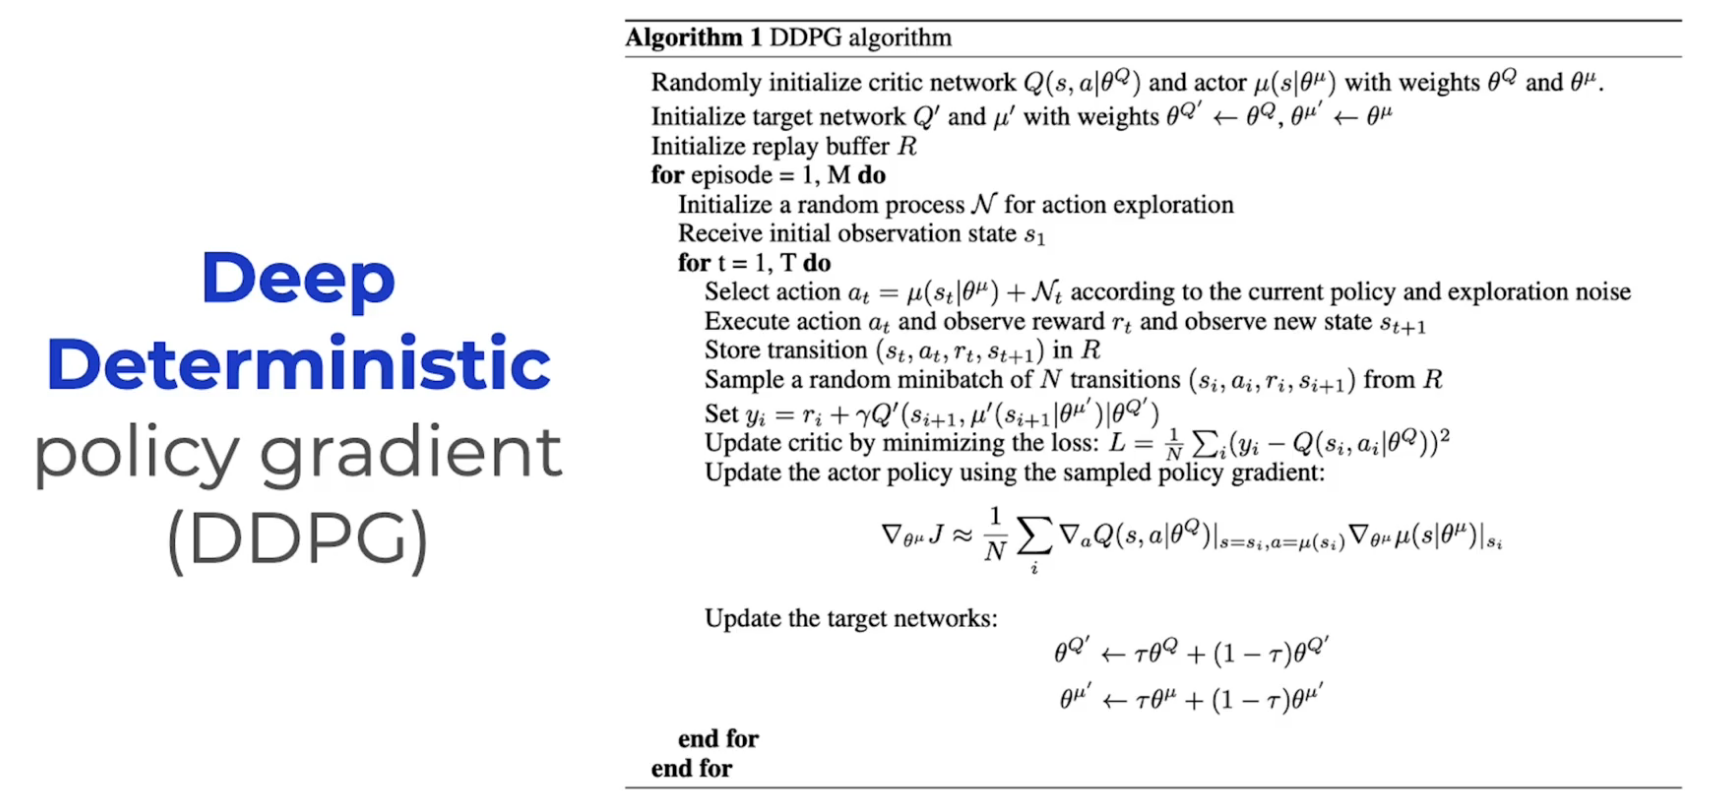

#### Create the gradient policy

#### Create the Deep Q-Network